## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Step 1 : Calibrate the camera using chessboard images

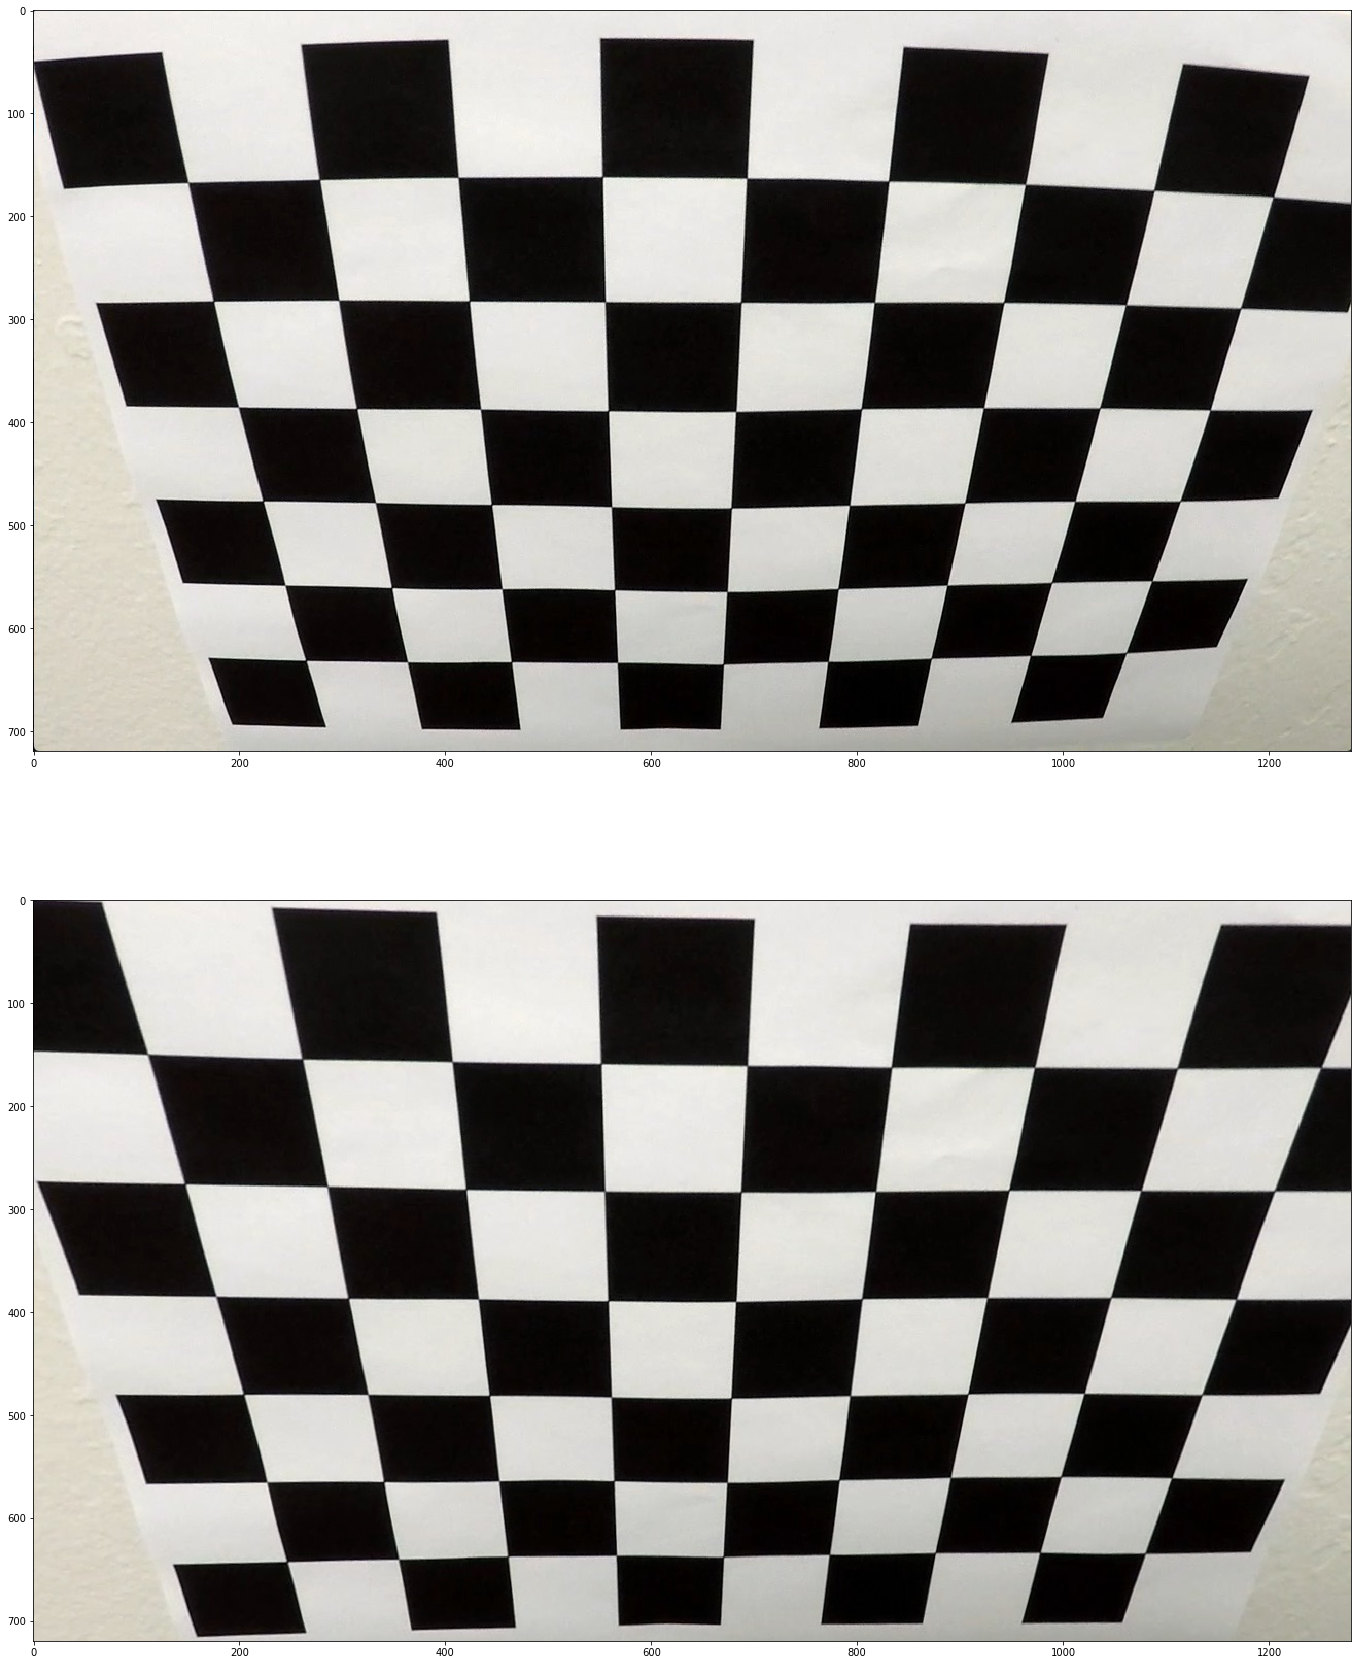

In [14]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Get all calibration images at our disposal:
# NOTE : I renamed calibration2.jpg from the calibration folder to use it to test our calibration matrix
calibration_images = glob.glob('camera_cal/calibration*.jpg')
    
# Using the code from the lesson :
# We first create a list of object points and image points that
# will enable us to use the opencv calibrate function
objpoints = []
imgpoints = []
    
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x,y coordinates
    
# Then, for each image in the calibration folder with get
# the object points
for image in calibration_images:
    img = mpimg.imread(image)
    # Grayscale conversion
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        
# Calibrate the camera from our imagepoints and object points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Now, let's test our calibration on an image
raw_img = mpimg.imread('./camera_cal/test.jpg')
dst = cv2.undistort(raw_img, mtx, dist, None, mtx)

figure, ax = plt.subplots(2,1 , figsize=(25,30))
ax[0].imshow(raw_img)
ax[1].imshow(dst)

figure.savefig('./output_images/undistorded.jpg')

## Step 2 : Test calibration on an image and display the undistorder image

In [ ]:
pwd

# Step 3 : Create a thresholded image 

# Step 4 : Apply perspective transform

# Step 5 : Find lane boundaries

# Step 6 : Determine curvature

# Step 7 : Warp detected lanes to original image

# Step 8 :  Output